In [1]:
%load_ext line_profiler
%load_ext autoreload

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.special import expit as sigmoid
from scipy.stats import norm
from scipy import integrate

import tqdm.notebook as tqdm

In [75]:
P = 500
d = 600
lamb = 1e-2
c = 1/3 #std of logistic noise

mu = np.zeros(d)
Sigma = np.eye(d)

x = np.random.multivariate_normal(mu, Sigma, P)

a0 = np.random.randn(d)
a0 = np.sqrt(d) * a0 / np.linalg.norm(a0)

In [76]:
y = np.random.binomial(1, sigmoid(x @ a0 / (np.sqrt(d) * c)))*2 - 1 #scaled heaviside of logistic noise
y = y.reshape(-1, 1)

In [77]:
V = y * x@a0 / np.sqrt(d)

In [78]:
eta = lambda m: np.maximum(0, 1-m)**2
eta_p = lambda m: np.minimum(0, 2*(m-1))
eta_pp = lambda m: 2*(m < 1)

In [79]:
if d == 1:
    h1 = plt.hist(x[np.sign(V-1) == 1], density=True, bins=100, alpha=.8)
    h2 = plt.hist(x[np.sign(V-1) == -1], density=True, bins=100, alpha=.8)

In [80]:
"""
    Minimizing squared hinge loss with small regularization on the weights. 
    This gives us an L2-regularized L2-loss SVM:
        https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf#equation.A.1
"""
import liblinear
import liblinearutil
import os

C = 1/lamb #might need to go into the documentation and fiddle with this to make sure we are using the correct regularization

model = liblinearutil.train(y.reshape(-1), np.array(x), f'-s 1 -n {os.cpu_count()} -c {C}')
p_label, p_acc, p_val = liblinearutil.predict(y.reshape(-1), np.array(x), model, '-q')

a_hat = [model.get_decfun_coef(i+1) for i in range(d)]
a_hat = np.array(a_hat)*np.sqrt(d)

In [81]:
if d == 2:
    H = lambda a: C*np.sum(eta(y * x@a / np.sqrt(d)), 0) + 1/2*(a**2).sum(0)

    gx = np.linspace(a0[0]-10, a0[0]+10, 200)
    gy = np.linspace(a0[1]-10, a0[1]+10, 200)
    xx, yy = np.meshgrid(gx, gy)
    XY = np.stack((xx, yy)).reshape(2, -1)

    HXY = H(XY)

    argmin = np.unravel_index(np.argmin(HXY), (len(gx), len(gy)))
    a_hat_geom = [gx[argmin[1]], gy[argmin[0]]]

    plt.contourf(gx, gy, np.log(HXY).reshape(len(gx), len(gy)), 20)
    plt.scatter(a0[0], a0[1])
    plt.scatter(a_hat_geom[0], a_hat_geom[1], c='green')
    plt.scatter(a_hat[0], a_hat[1], c='orange')
    plt.plot([0, a0[0]*3], [0, a0[1]*3], c='red')
    plt.colorbar()
    
    print(a_hat)

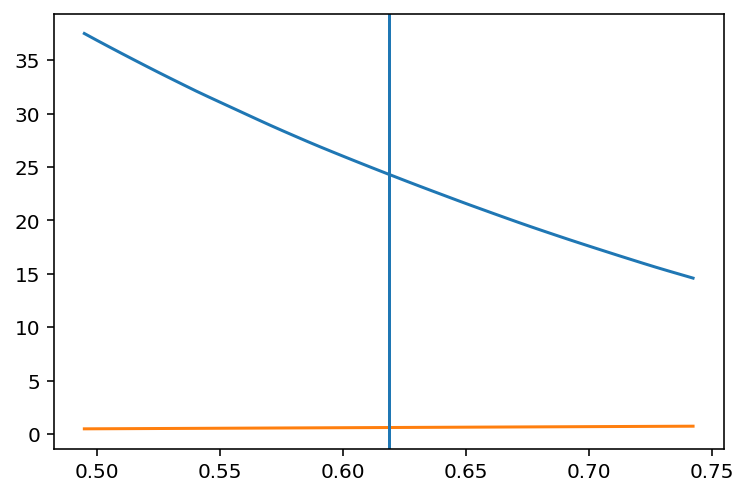

In [82]:
alpha_hat = (a_hat @ a0)/d

alphas = np.linspace(.8*alpha_hat,1.2*alpha_hat)

plt.plot(alphas, -(1/(lamb*d))*np.sum(eta_p((alphas * V[:,None]))*V[:,None], 0))
plt.plot(alphas, alphas)

plt.axvline(alpha_hat)

In [83]:
if d == 2:
    Hpp = np.linalg.pinv(np.mean((eta_pp(alpha_hat*V)[:,None,None]*np.einsum('na,nb->nab', x, x)/d) + lamb, 0))/100
    
    plt.contourf(gx, gy, np.log(HXY).reshape(len(gx), len(gy)))
    plt.scatter(a0[0], a0[1])
    plt.scatter(a_hat[0], a_hat[1], c='green')
    plt.plot([0, a0[0]*3], [0, a0[1]*3], c='red')
    plt.colorbar()
    
    a_samp = np.random.multivariate_normal(alpha_hat*a0, Hpp, 100)
    plt.scatter(a_samp[:,0], a_samp[:,1])

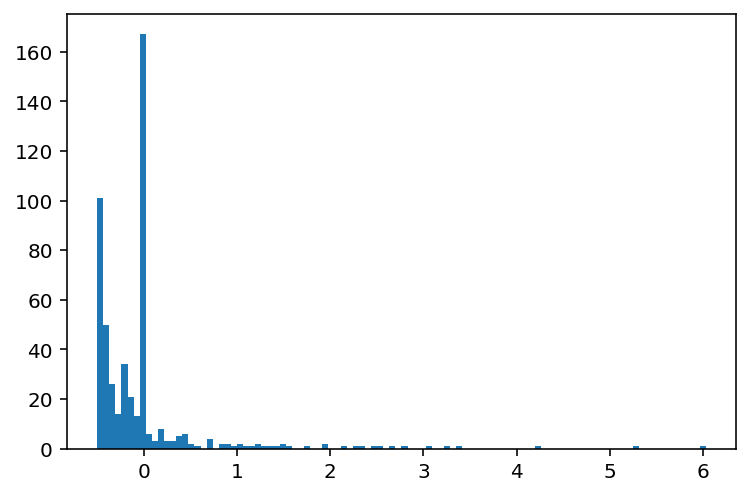

In [84]:
hist = plt.hist(eta_p(V)*V, bins = 100)

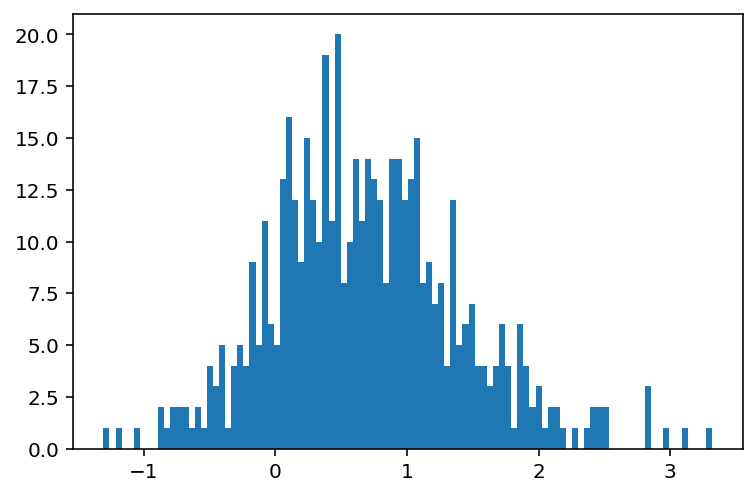

In [85]:
hist = plt.hist(V, bins = 100)

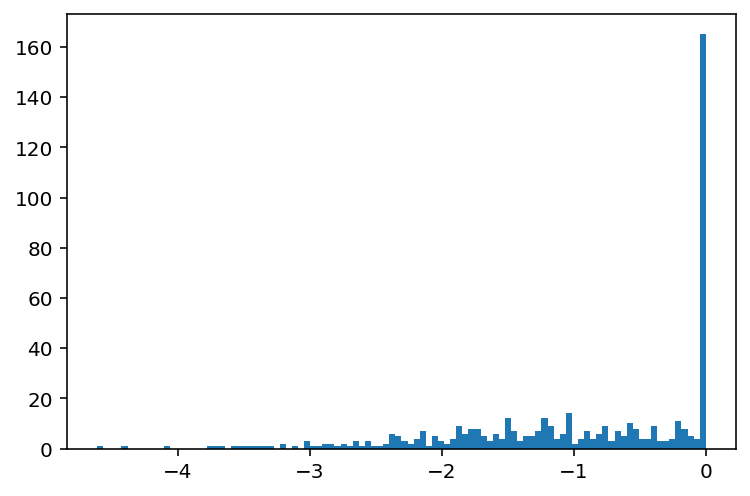

In [86]:
hist = plt.hist(eta_p(V), bins = 100)

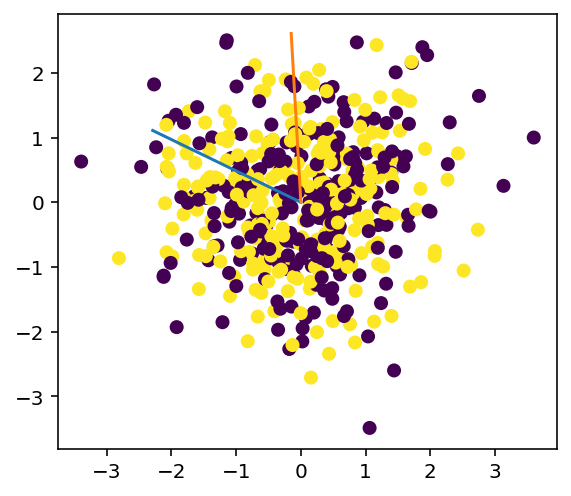

In [87]:
plt.scatter(x[:,0], x[:,1], c = y.ravel())
plt.plot([0,a_hat[0]], [0, a_hat[1]])
plt.plot([0,a0[0]], [0, a0[1]])
plt.gca().set_aspect('equal')

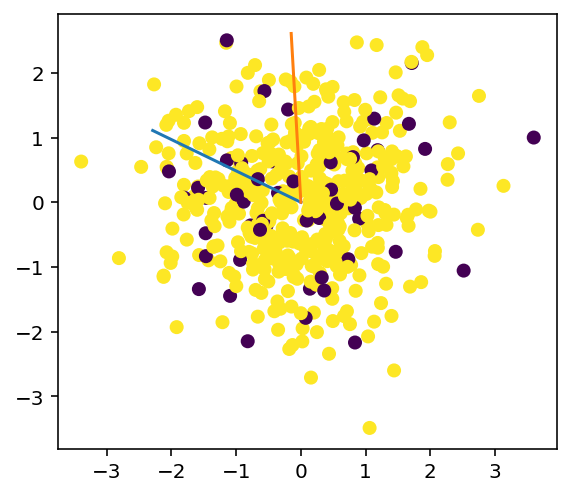

In [88]:
plt.scatter(x[:,0], x[:,1], c = eta_pp(alpha_hat*V))
plt.plot([0,a_hat[0]], [0, a_hat[1]])
plt.plot([0,a0[0]], [0, a0[1]])
plt.gca().set_aspect('equal')

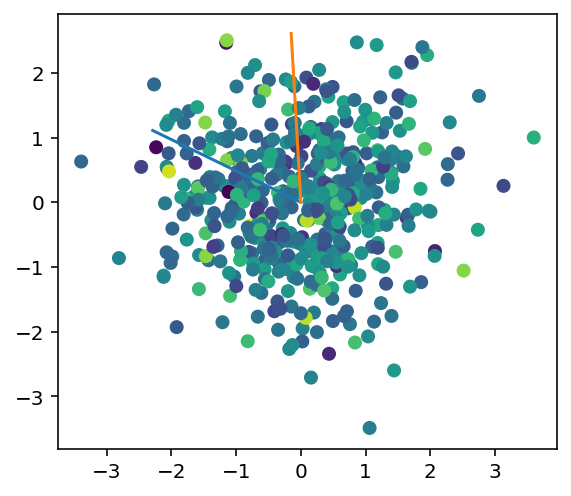

In [89]:
plt.scatter(x[:,0], x[:,1], c = np.array(V).ravel())
plt.plot([0,a_hat[0]], [0, a_hat[1]])
plt.plot([0,a0[0]], [0, a0[1]])
plt.gca().set_aspect('equal')

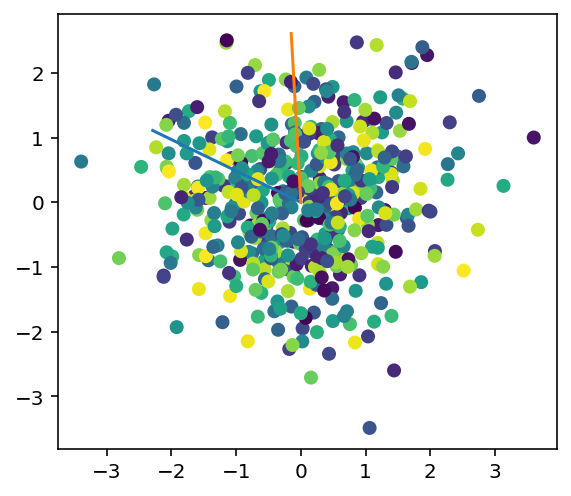

In [90]:
plt.scatter(x[:,0], x[:,1], c = norm.cdf(x@a0 / np.sqrt(d)).ravel())
plt.plot([0,a_hat[0]], [0, a_hat[1]])
plt.plot([0,a0[0]], [0, a0[1]])
plt.gca().set_aspect('equal')

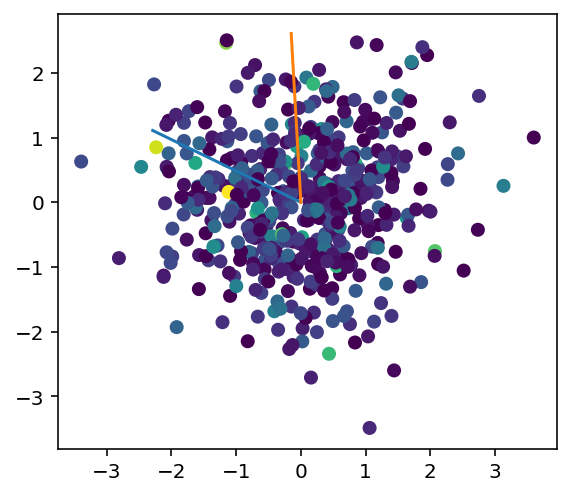

In [91]:
plt.scatter(x[:,0], x[:,1], c = eta(alpha_hat*np.array(V).ravel()))
plt.plot([0,a_hat[0]], [0, a_hat[1]])
plt.plot([0,a0[0]], [0, a0[1]])
plt.gca().set_aspect('equal')

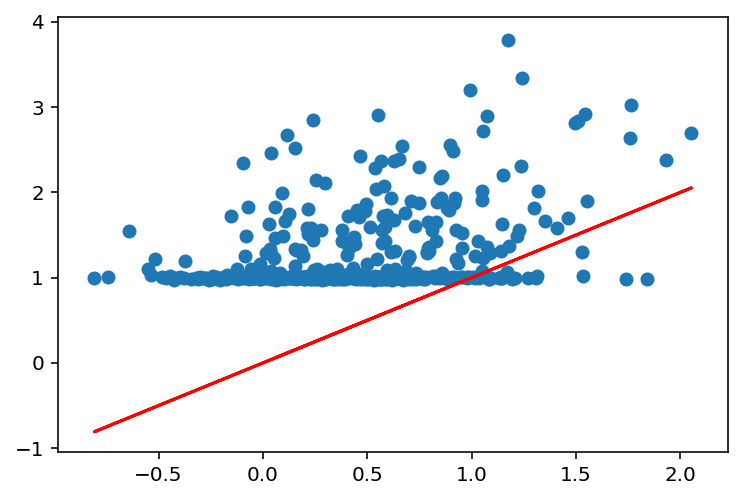

In [92]:
plt.plot(alpha_hat*V, alpha_hat*V, color='r')
plt.scatter(alpha_hat*V, y * x @ a_hat / np.sqrt(d))

In [93]:
# plt.scatter(*(eta_pp(alpha_hat*V)[:,None] * x).T)

In [94]:
thing = (eta_pp(alpha_hat*V)[:,None] * x)

In [95]:
eigs = np.linalg.eigvalsh(thing.T @ thing/d)

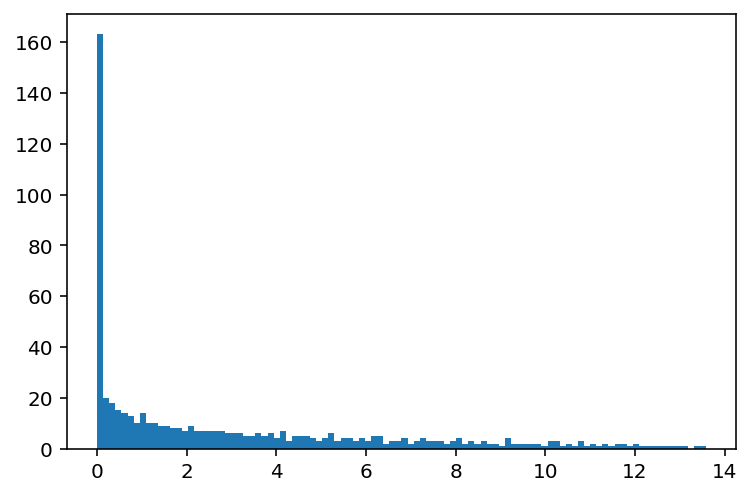

In [99]:
hist=plt.hist(eigs, 100)

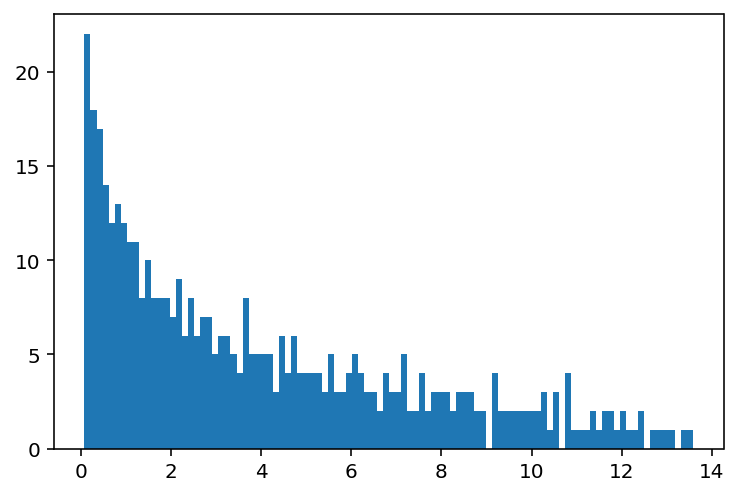

In [100]:
hist=plt.hist(eigs[eigs>1e-5], 100)

In [101]:
np.min(eigs[eigs>1e-5]) # gap!

0.07874622172907775